In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from Model import Model, accuracy
from Utils import split_np

In [2]:
iris = datasets.load_iris(as_frame=False)
seed = 42
train_x, train_y, val_x, val_y = split_np(iris['data'], iris['target'], 0.2, seed)
indices = np.int32(np.floor(np.linspace(0, train_y.size, 6)))
folds = np.empty((5, 2), dtype=int)
folds[:, 0] = indices[:-1]
folds[:, 1] = indices[1:]

In [3]:
K = [lambda r: 1 / (r + 1),
    lambda r: 0.75 * (1 - r**2) * (np.abs(r) < 1),
    lambda r: 15/16 * (1 - r**2)**2 * (np.abs(r) < 1),
    lambda r: (1 - np.abs(r)) * (np.abs(r) < 1),
    lambda r: 1 / np.sqrt(2*np.pi) * np.exp(-r**2/2)]
D = [lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, -1)),
    lambda x1, x2: np.sum(np.abs(x1 - x2), -1),
    lambda x1, x2: np.sum((x1 - x2)**2, -1)]
H = [0.001, 0.01, 0.1, 1.0, 2.5]
hp = list(itertools.product(np.arange(len(K)), np.arange(len(D)), H))

In [ ]:
best_param = []
best_accuracy = 0
for ki, di, h in hp:
    print(ki, di, h)
    sum_acc = 0
    for begin, end in folds:
        model = Model(K[ki], D[di], h)
        ar = np.arange(begin, end)
        if not model.fit(np.delete(train_x, ar, 0), np.delete(train_y, ar, 0), 3, max_time=10, min_train_acc=0.99):
            sum_acc = 0
            break
        sum_acc += accuracy(model.predict(train_x[begin:end]), train_y[begin:end])
    sum_acc /= folds.shape[0]
    if sum_acc > best_accuracy:
        best_accuracy = sum_acc
        best_param = [(ki, di, h)]
    elif np.abs(sum_acc - best_accuracy) < 1e-8:
        best_param += [(ki, di, h)]

In [6]:
for ki, di, h in best_param:
    model = Model(K[ki], D[di], h)
    model.fit(train_x, train_y, 3)
    print(ki, di, h, ": ", accuracy(model.predict(val_x), val_y))

0 1 0.001 :  0.9666666666666667
0 1 0.01 :  0.9666666666666667
0 2 0.1 :  0.9333333333333333
4 0 1.0 :  0.9333333333333333


In [ ]:
import matplotlib.pyplot as plt
r = np.linspace(0, 5, 100)
plt.plot(r, K[4](r))
plt.plot(r, K[0](r/0.1))
plt.plot(r, K[1](r))

In [121]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(30)
model.fit(train_x, train_y)
preds = model.predict(val_x)
mask = preds != val_y
print("%.2f" % (np.sum(preds == val_y) / val_y.size))
print(val_x[mask])
print(val_y[mask])
print(preds[mask])

0.93
[[6.  2.2 5.  1.5]
 [6.3 2.8 5.1 1.5]]
[2 2]
[1 1]


In [42]:
class Plotter:
    def __init__(self, model, train_x, train_y, val_x, val_y):
        preds = model.predict(val_x.to_numpy())
        train_x = train_x.assign(col = train_y)
        val_x = val_x.assign(col = 3 + val_y.to_numpy() * 3 + preds * 9)
        self.res = pd.concat((train_x, val_x))

    def Plot(self, gt, y):
        sns.pairplot(self.res[(self.res['col'] == 3 + gt * 3 + y * 9) | (self.res['col'] < 3)], hue='col', palette={0: 'y', 1: 'b', 2: 'g', 3 + gt * 3 + y * 9: 'r'})

def PlotSample(x, y):
    res = pd.DataFrame(x, columns=iris['feature_names']).assign(color = y)
    sns.pairplot(res, hue='color', palette={0: 'y', 1: 'b', 2: 'g'})

def PlotSamples(xs, ys):
    res = pd.DataFrame(xs[0], columns=iris['feature_names']).assign(color = ys[0])
    for i in range(1, len(xs)):
        res = pd.concat((res, pd.DataFrame(xs[i], columns=iris['feature_names']).assign(color = ys[i])))
    sns.pairplot(res, hue='color', palette={0: 'y', 1: 'b', 2: 'g', 3: 'r', 4: 'black', 5: 'orange'})

In [43]:
ind = np.arange(train_y.size)
np.random.shuffle(ind)
new_train_x = train_x[ind]
new_train_y = train_y[ind]

In [130]:
model = Model(k, d , 0.1)
model.fit(new_train_x, new_train_y, 3)

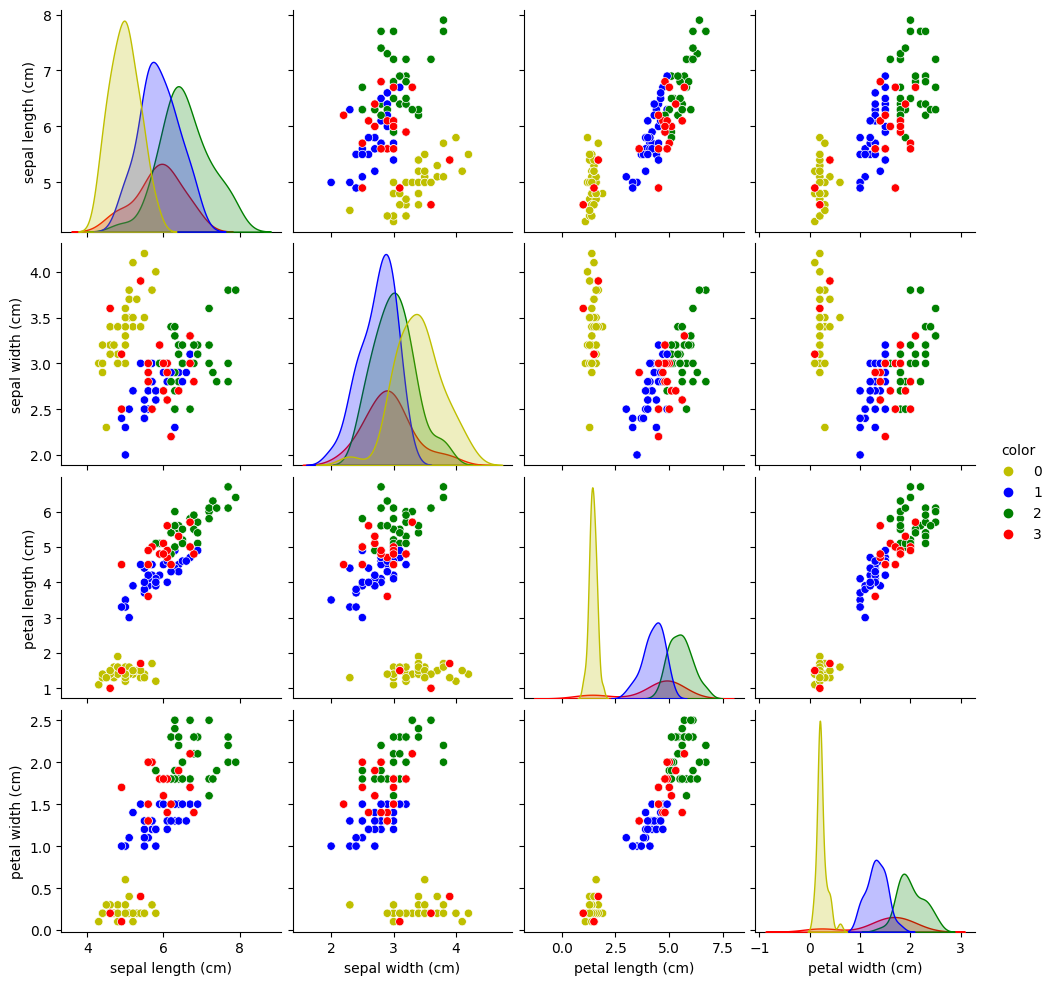

In [131]:
PlotSamples([new_train_x, model.x], [new_train_y, np.ones_like(model.y)*3])

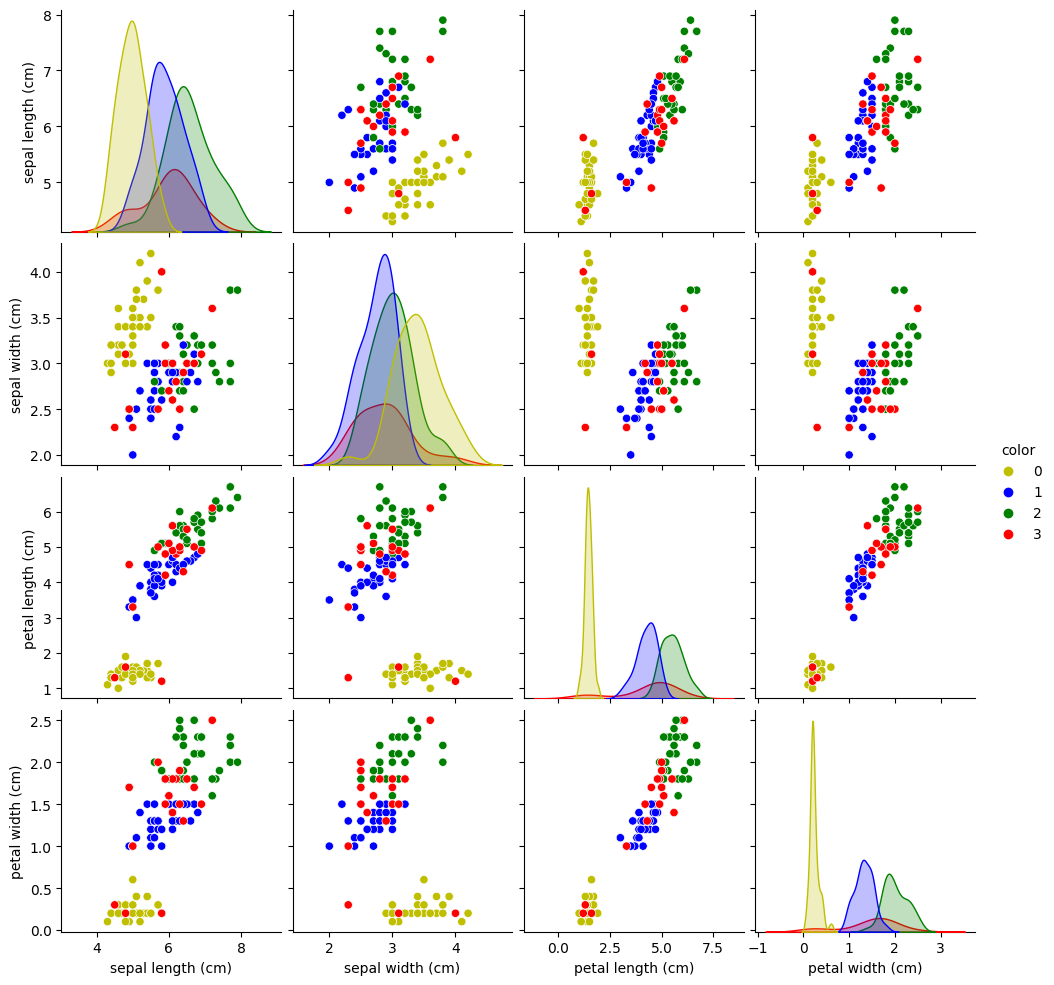

In [124]:
i = 3
PlotSamples([train_x, models_from_0[i].x], [train_y, np.ones_like(models_from_0[i].y)*3])

In [35]:
model = models_from_0[1]
preds = model.predict(val_x)
mask = preds != val_y
print(val_y[mask])
print(preds[mask])
plotter = Plotter(model, *dataset_frame.split(0.2, seed))

[0 2]
[2 1]


In [127]:
xs = train_x
n = xs.shape[0]
ds = np.empty(n * (n - 1) // 2)
id = 0
for i in range(n - 1):
    for j in range(i+1, xs.shape[0]):
        ds[id] = d(xs[i], xs[j])
        id+=1
print(np.mean(ds))
print(np.min(ds[ds>0]))
print(np.max(ds))
print(np.median(ds))
print(models_from_0[3].gamma)

2.526373120919795
0.1414213562373093
6.926037828369117
2.3032583055024256
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


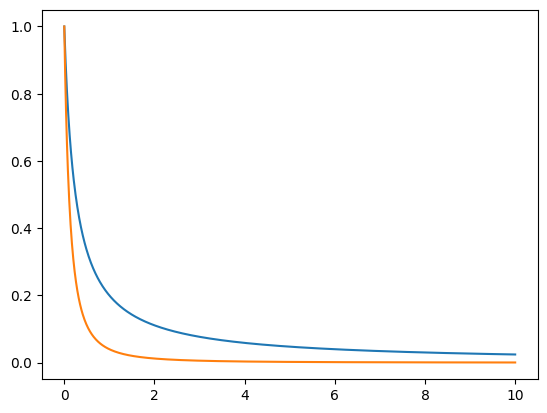

In [126]:
import matplotlib.pyplot as plt
x = np.linspace(0, 10, 1000)
plt.plot(x, 1 / (1 + x/0.25))
plt.plot(x, 1 / (1 + x/0.25)**2)